<a href="https://colab.research.google.com/github/SachinPrasanth777/PyTorch/blob/main/Caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!mkdir -p coco_data
!unzip -q train2017.zip -d coco_data/
!unzip -q annotations_trainval2017.zip -d coco_data/
!rm train2017.zip annotations_trainval2017.zip

--2025-02-16 08:51:41--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.177.74, 52.216.28.44, 52.217.225.25, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.177.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  58.3MB/s    in 5m 45s  

2025-02-16 08:57:26 (53.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-02-16 08:57:26--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.30.234, 3.5.20.39, 3.5.29.240, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.30.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 10

In [1]:
import os
print(os.listdir("coco_data"))
print(os.listdir("coco_data/annotations"))

['annotations', 'train2017']
['captions_val2017.json', 'person_keypoints_train2017.json', 'person_keypoints_val2017.json', 'instances_train2017.json', 'captions_train2017.json', 'instances_val2017.json']


loading annotations into memory...
Done (t=21.35s)
creating index...
index created!


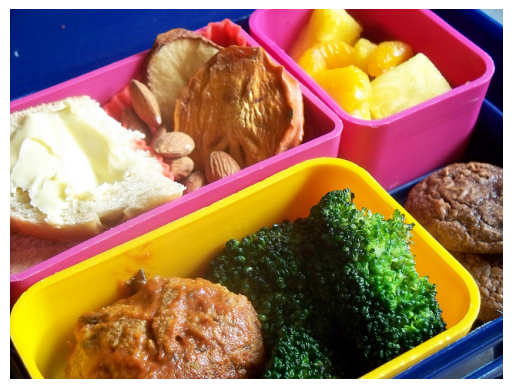

Captions for this image:
1. Closeup of bins of food that include broccoli and bread.
2. A meal is presented in brightly colored plastic trays.
3. there are containers filled with different kinds of foods
4. Colorful dishes holding meat, vegetables, fruit, and bread.
5. A bunch of trays that have different food.


In [19]:
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import json
import random

coco_dataset = datasets.CocoDetection(
    root="coco_data/train2017",
    annFile="coco_data/annotations/instances_train2017.json",
    transform=transforms.ToTensor()
)
with open("coco_data/annotations/captions_train2017.json", "r") as f:
    captions_data = json.load(f)
    img, target = coco_dataset[0]

image_id = target[0]['image_id']
captions = [ann["caption"] for ann in captions_data["annotations"] if ann["image_id"] == image_id]
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()
print("Captions for this image:")
for i, caption in enumerate(captions):
    print(f"{i+1}. {caption}")

In [ ]:
!pip install nltk torch torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import nltk
import json
import string
import numpy as np
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu

nltk.download('punkt_tab')

In [21]:
class COCOCaption(Dataset):
    def __init__(self, image_dir, caption_file, transform=None, max_samples=10000):
        with open(caption_file, 'r') as f:
            self.coco_data = json.load(f)
        self.image_dir = image_dir
        self.transform = transform
        all_img_ids = list(set(ann["image_id"] for ann in self.coco_data["annotations"]))
        random.seed(42)
        self.img_ids = random.sample(all_img_ids, min(max_samples, len(all_img_ids)))
        self.img_captions = {}
        for ann in self.coco_data["annotations"]:
            if ann["image_id"] in self.img_ids:
                self.img_captions[ann["image_id"]] = self.preprocess_caption(ann["caption"])
        self.vocab = self.build_vocab()

    def preprocess_caption(self, caption):
        caption = caption.lower()
        caption = caption.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(caption)
        return ["<start>"] + tokens + ["<end>"]

    def build_vocab(self):
        word_freq = Counter()
        for caption in self.img_captions.values():
            word_freq.update(caption)
        vocab = {word: idx for idx, (word, _) in enumerate(word_freq.items(), start=1)}
        vocab["<pad>"] = 0
        return vocab

    def encode_caption(self, caption):
        return [self.vocab.get(word, self.vocab["<pad>"]) for word in caption]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_filename = os.path.join(self.image_dir, f"{img_id:012d}.jpg")

        try:
            image = Image.open(img_filename).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: {img_filename} not found.")
            return None

        caption = self.encode_caption(self.img_captions.get(img_id, ["<start>", "<end>"]))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(caption)


In [22]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    resnet = models.resnet50(pretrained=True)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)

  def forward(self,x):
    with torch.no_grad():
      features = self.resnet(x)
    return features.view(features.size(0),-1)

In [23]:
class LSTM(nn.Module):
  def __init__(self,embed_size,hidden_size,vocab_size,num_layers):
    super(LSTM,self).__init__()
    self.embedding = nn.Embedding(vocab_size,embed_size)
    self.lstm = nn.LSTM(embed_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size,vocab_size)
    self.feature_proj = nn.Linear(2048, embed_size)

  def forward(self,features,captions):
    embeddings = self.embedding(captions)
    features = self.feature_proj(features)
    inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    lstm_out, _ = self.lstm(inputs)
    outputs = self.fc(lstm_out)
    return outputs

In [24]:
class ImageCaptioningModel:
    def __init__(self, image_dir, caption_file, batch_size=32, embed_size=256, hidden_size=512, num_layers=1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.dataset = COCOCaption(image_dir, caption_file, transform)
        self.dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True, collate_fn=self.collate_fn)
        self.vocab_size = len(self.dataset.vocab)
        self.model = self.build_model(embed_size, hidden_size,num_layers)

    def build_model(self, embed_size, hidden_size, num_layers):
        cnn = CNN()
        lstm = LSTM(embed_size, hidden_size, self.vocab_size, num_layers)
        return cnn.to(self.device), lstm.to(self.device)

    def collate_fn(self, batch):
        images, captions = zip(*batch)
        images = torch.stack(images).to(self.device)
        max_len = max(len(cap) for cap in captions)
        padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long).to(self.device)
        for i, cap in enumerate(captions):
            padded_captions[i, :len(cap)] = cap
        return images, padded_captions

    def train(self, num_epochs=10, learning_rate=0.001):
        cnn, lstm = self.model
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            total_loss = 0
            for images, captions in self.dataloader:
                features = cnn(images)
                outputs = lstm(features, captions[:, :-1])
                target_lengths = (captions[:, 1:] != 0).sum(dim=1)
                target = captions[:, 1:][captions[:, 1:] != 0]
                outputs = outputs.reshape(-1, self.vocab_size)
                outputs = outputs[:target.shape[0]]
                loss = criterion(outputs, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(self.dataloader):.4f}")

    def evaluate(self, image_path):
        cnn, lstm = self.model
        cnn.eval()
        lstm.eval()

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        image = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(self.device)
        feature = cnn(image)
        caption = ["<start>"]

        for _ in range(20):
            input_seq = torch.tensor([self.dataset.vocab.get(word, 0) for word in caption]).unsqueeze(0).to(self.device)
            output = lstm(feature, input_seq)
            predicted_id = output.argmax(2)[:, -1].item()
            word = [key for key, val in self.dataset.vocab.items() if val == predicted_id]
            if word == ["<end>"] or not word:
                break
            caption.append(word[0])

        print("Generated Caption:", " ".join(caption[1:]))

In [25]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(reference_captions, predicted_caption):
    score = sentence_bleu(reference_captions, predicted_caption)
    print("BLEU Score:", score)

In [26]:
model = ImageCaptioningModel("coco_data/train2017", "coco_data/annotations/captions_train2017.json")
model.train()

Epoch [1/10], Loss: 5.5921
Epoch [2/10], Loss: 5.4669
Epoch [3/10], Loss: 5.4606
Epoch [4/10], Loss: 5.4567
Epoch [5/10], Loss: 5.4529
Epoch [6/10], Loss: 5.4516
Epoch [7/10], Loss: 5.4491
Epoch [8/10], Loss: 5.4473
Epoch [9/10], Loss: 5.4459
Epoch [10/10], Loss: 5.4439


In [33]:
model.evaluate("coco_data/train2017/000000000025.jpg")

Generated Caption: a a a a a a a a a a a a a a a a a a a a
